In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import torch
from torch.autograd import Variable
from torch.utils import data
from torch import nn
from torch import optim
from torch.utils import data

from sklearn.metrics import r2_score, mean_squared_error


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

import sys
sys.path.append('..')#
from util import add_angles, angle_between, angled_vector, sub_angles
from mdn_model.mixture_loss import *
from mdn_model.models import *

cuda:0


In [325]:
df_train = pd.read_csv( '../../data/processed/rf_train.csv')
df_test = pd.read_csv( '../../data/processed/rf_test.csv')

# Put dt column last for both dfs.
# Otherwise reshaping will have weird results.
cols = list(df_train.columns)
cols.remove('dt')
df_train = df_train[cols + ['dt']]
df_test = df_test[cols + ['dt']]

y_labels = ['y_0', 'y_1']
y_train_np = df_train.loc[df_train['dt'] == 0, y_labels].values
y_test_np = df_test.loc[df_train['dt'] == 0, y_labels].values

n_dts = len(np.unique(df_train['dt']))
n_features = df_train.shape[1] - 3# # minus rows dt, y_0, y_1

X_train_np = df_train.drop(labels=y_labels + ['dt'], axis=1).values
X_test_np = df_test.drop(labels=y_labels + ['dt'], axis=1).values

# Reshape from (dts*kicks, features) to (kicks, dts, n_features)
X_train_np = X_train_np.reshape(X_train_np.shape[0]//n_dts, n_dts, n_features)
X_test_np = X_test_np.reshape(X_test_np.shape[0]//n_dts, n_dts, n_features)

# Transpose to (dts, kicks, features)
X_train_np = X_train_np.transpose(1,0, 2)
X_test_np = X_test_np.transpose(1,0, 2)

# Reverse order of timesteps s.t. dt=0 is last
X_train_np = X_train_np[::-1,:,:].copy()
X_test_np = X_test_np[::-1,:,:].copy()

# To Tensors
X_train = torch.from_numpy(X_train_np).float()
y_train = torch.from_numpy(y_train_np).float()

X_test = torch.from_numpy(X_test_np).float()
y_test = torch.from_numpy(y_test_np).float()



class LSTMDataset(data.Dataset):
    def __init__(self, X, y):
        super(data.Dataset, self).__init__
        
        self.X = X
        self.y = y
        
    def __len__(self):
        return self.X.shape[1]
    
    def __getitem__(self, idx):
        return self.X[:, idx,:], self.y[idx,:]

train_data = LSTMDataset(X_train, y_train)

def collate(batch):
    result = []
    Xs = []
    ys = []
    for elem in batch:
        X = elem[0]
        y = elem[1]
        Xs.append(X)
        ys.append(y)
    return torch.stack(Xs, dim=1), torch.stack(ys, dim=0)

train_loader = data.DataLoader(train_data,
                               batch_size=128, 
                               collate_fn=collate,
                               pin_memory=True,
                               num_workers=6,
                               # Need to ensure batch sizes are identical
                               shuffle=True,
                               drop_last=False)

X_train.shape

torch.Size([7, 18992, 192])

In [9]:
checkpoint = torch.load('../../checkpoints/tmp_900.pt')
covariance_type = 'general'

n_hidden = 64 # 32 doesnt work, 128 too much?
#encoder = RNNEncoder(n_features=n_features, n_hidden=n_hidden, n_layers=1)

#encoder = RNNEncoder(n_features=n_features, n_hidden=n_hidden)
encoder = MLPEncoder(n_features=n_features, n_hidden=n_hidden)
decoder = MDNDecoder(n_hidden=n_hidden, n_components=3, covariance_type=covariance_type, covariance_reg=1e-6)
#decoder = NormalDecoder(n_hidden=n_hidden)

model = ReceptiveFieldNN(encoder=encoder, decoder=decoder).to(device)
model.load_state_dict(checkpoint['model'])
model.eval()

ReceptiveFieldNN(
  (encoder): MLPEncoder(
    (in_to_hidden): Sequential(
      (0): Linear(in_features=192, out_features=64, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.5)
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): Tanh()
      (5): Dropout(p=0.5)
    )
  )
  (decoder): MDNDecoder(
    (z_pi): Linear(in_features=64, out_features=3, bias=True)
    (z_sigma): Linear(in_features=64, out_features=9, bias=True)
    (z_mu): Linear(in_features=64, out_features=6, bias=True)
  )
)

array([[ 0.90741589,  0.76011441],
       [ 2.00254111,  0.06359809],
       [ 2.28915773,  0.24762134],
       [-0.33929076,  0.20421084],
       [ 1.24104199,  0.1956479 ],
       [ 0.81884618, -0.25610641],
       [ 1.20727719,  0.39927425],
       [ 1.29132696, -0.26379418],
       [ 1.62492454,  0.21125606],
       [ 1.27032509,  0.3709869 ]])

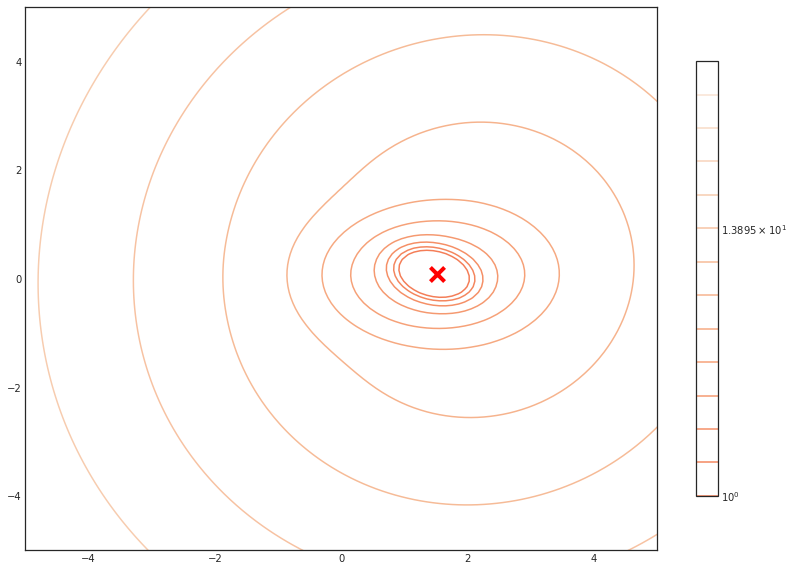

In [562]:
from abc import ABC, abstractmethod

def compute_covar_matrix(sigma):
    sigma = np.vstack([sigma[:,0], np.zeros_like(sigma[:,0]), sigma[:,1], sigma[:,2]]).T
    sigma = sigma.reshape(-1,2,2)
    sigma = np.matmul(sigma,sigma.transpose(0,2,1))
    return sigma

def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

def mixture_sample(pi, mu, sigma, n_samples):    
    # First sample from component distribution.
    components = gumbel_sample(np.tile(pi,n_samples).reshape(n_samples,-1))

    components, component_samples = np.unique(components, return_counts=True)

    samples = []
    for idx, size in zip(components, component_samples):
        # Note that without increased tolerance numpy thinks our matrices aren't positive
        # semidefinit even though they are by construction!
        samples.append(np.random.multivariate_normal(mean=mu[idx],
                                                     cov=sigma[idx],
                                                     size=size,
                                                     check_valid='raise',
                                                     tol=1e-6))
    return np.vstack(samples)

class SocialModel(ABC):
    @abstractmethod
    def __init__(self):
        pass
    
    @abstractmethod
    def predict(self, receptive_field):
        pass
    
    @abstractmethod
    def sample(self, receptive_field, n_samples=1):
        pass
    
    @abstractmethod
    def contour(self, receptive_field, ax):
        pass
    
    @abstractmethod
    def get_required_timesteps(self):
        pass
    
class MixtureModel(SocialModel):
    def __init__(self, model):
        self.model = model
        assert(isinstance(self.model.decoder, MDNDecoder))
        self.covariance_type = self.model.decoder.covariance_type

        if isinstance(self.model.encoder, RNNEncoder):
            self.encoder_type = 'rnn'
        else:
            self.encoder_type = 'mlp'
            
    def evaluate_(self, receptive_field):
        self.model.eval()
        
        # First evaluate the model
        with torch.no_grad():
            out = model(receptive_field)
            
        to_numpy = lambda o: o.squeeze(0).detach().cpu().numpy()
        pi, sigma, mu = [to_numpy(o) for o in out]
        
        # Compute covariance matrices
        if self.covariance_type == 'diagonal':
            sigma = np.stack((np.diag(s) for s in sigma), axis=0)
        else:
            sigma = compute_covar_matrix(sigma)
        
        return pi, sigma, mu
        
    def predict(self, receptive_field):
        pi, _, mu = self.evaluate_(receptive_field)
        return (np.stack((pi, pi), axis=-1) *  mu).sum(axis=1)
        
    def sample(self, receptive_field, n_samples=1):
        pi, sigma, mu = self.evaluate_(receptive_field)
            
        samples = mixture_sample(pi, mu, sigma, n_samples=n_samples)
        return samples    

    def contour(self, receptive_field, ax):
        pi, sigma, mu = self.evaluate_(receptive_field)
        return contour_gmm(pi, sigma, mu, ax)
    
    def get_required_timesteps(self):
        if self.encoder_type == 'rnn':
            return np.linspace(0, 35, num=35//5+1)
        else:
            return np.array([0])
        
idx = np.random.randint(low=0,
                        high=len(y_test))
social_model = MixtureModel(model)       
social_model.get_required_timesteps()
fig, ax = plt.subplots(figsize=(2**0.5*10, 10))
social_model.contour(X_test[:,idx:idx+1,:].to(device), ax=ax)
social_model.sample(X_test[:,idx:idx+1,:].to(device), n_samples=10)

In [408]:
sns.set_style('white')
from scipy import stats
from matplotlib import colors
from mdn_model.mixture_loss import log_sum_exp

def compute_covar_matrix(sigma):
    sigma = np.vstack([sigma[:,0], np.zeros_like(sigma[:,0]), sigma[:,1], sigma[:,2]]).T
    sigma = sigma.reshape(-1,2,2)
    sigma = np.matmul(sigma,sigma.transpose(0,2,1))
    return sigma

def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

def mixture_sample(pi, mu, sigma, n_samples):   
    # First sample from component distribution.
    components = gumbel_sample(np.tile(pi,n_samples).reshape(n_samples,-1))

    components, component_samples = np.unique(components, return_counts=True)

    samples = []
    for idx, size in zip(components, component_samples):
        # Note that without increased tolerance numpy thinks our matrices aren't positive
        # semidefinit even though they are by construction!
        samples.append(np.random.multivariate_normal(mean=mu[idx],
                                                     cov=sigma[idx],
                                                     size=size,
                                                     check_valid='raise',
                                                     tol=1e-6))
    return np.vstack(samples)

def contour_gmm(pi, sigma, mu, ax):
    sns.set_style('white')
    x = np.linspace(-10,10, num=200)
    y = np.linspace(-10,10, num=200)
    X, Y = np.meshgrid(x,y)
    XX = np.array([X.ravel(), Y.ravel()]).T

    #Z = np.zeros_like(X)*1.0
    Z = []
    mean = np.array([0.,0])
    for p, s, m in zip(pi, sigma, mu):
        gaussian = stats.multivariate_normal(mean=m, cov=(s))
        mean += p*m
        ll = gaussian.logpdf(XX)
        ll = ll.reshape(X.shape)
        Z.append(np.log(p) + ll)
        #Z +=  p * ll

    Z = -log_sum_exp(torch.tensor(Z), dim=0)

    vmin, vmax = Z.min(), Z.max()
    cs = ax.contour(X,Y,Z, levels=np.logspace(0, 2, num=15), norm=colors.SymLogNorm(linthresh=0.01, vmin=vmin, vmax=vmax),)
    fig.colorbar(cs, shrink=0.8, extend='both')
    mu_x, mu_y = np.hsplit(mu, [1])
    #ax.scatter(mu_x, mu_y, c='green', marker='x', s=200, zorder=10, linewidth=4, label='component')
    #ax.scatter(vector_gt[0], vector_gt[1], c='blue', marker='x', s=200, zorder=10, linewidth=4, label='gt')
    ax.scatter(mean[0], mean[1], c='red', marker='x', s=200, zorder=10, linewidth=4, label='pred')

    #ax.legend(frameon=True)
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)

def multivariate_sample(mu_, sigma_):
    return np.vstack([np.random.multivariate_normal(m, s) for m, s in zip(mu_, sigma_)])

In [256]:
y_train_hat = social_model.predict(X_train.to(device))
y_test_hat = social_model.predict(X_test.to(device))
# Angle error, https://stats.stackexchange.com/questions/197639/calculating-goodness-of-fit-for-circular-data

def compute_angles(vectors):
        return np.apply_along_axis(
            lambda x: angle_between(np.array([1,0]), x), 
            axis=1,
            arr=vectors)

def compute_angle_error(angles, angles_hat):
    return np.arccos(np.cos(angles - angles_hat)).sum()    

def compute_mean_angle(angles):
    return np.arctan2(np.sin(angles).sum(), np.cos(angles).sum())

angles = compute_angles(y_test_np)
angles_hat = compute_angles(y_test_hat)

angle_mean = np.ones_like(angles) * compute_mean_angle(angles)
vector_mean = np.ones_like(y_test_np) * y_test_np.mean(axis=0)
print(compute_angle_error(angles, angles_hat), compute_angle_error(angles, angle_mean))
print("MSE: ", mean_squared_error(y_test_np, y_test_hat), mean_squared_error(y_test_np, vector_mean))


1367.348613765939 1491.0960595295733
MSE:  0.37695070041589124 0.4247234768333282


In [433]:
social_model.sample(X_test[:, idx:idx+1, :].to(device))


array([[1.47451178, 0.08425728]])

[ 0.51671949 -0.29193237]


No handles with labels found to put in legend.


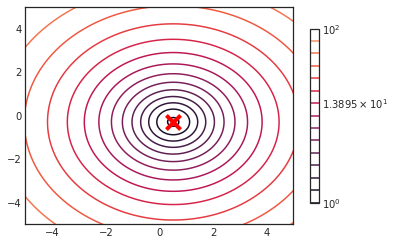

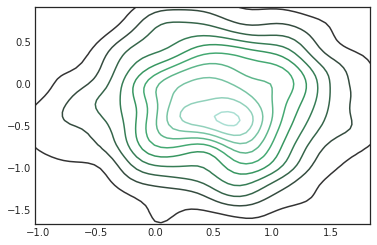

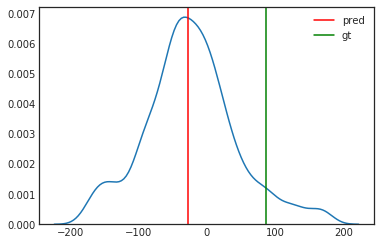

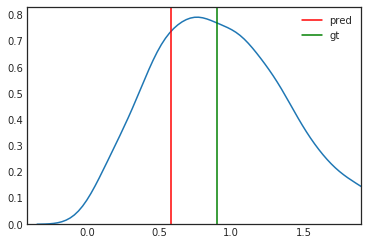

In [557]:
idx = random.choice(range(X_test.shape[0]))

data = X_test[:, idx:idx+1, :].to(device)
samples = social_model.sample(data, n_samples=1000)

vectors = torch.tensor(samples).float().numpy()
angles = np.rad2deg(np.apply_along_axis(lambda x: angle_between(np.array([1,0]), x), arr=vectors, axis=1))

vector_hat = vectors.mean(axis=0)
vector_gt = y_test[idx].numpy()
angle_gt = np.rad2deg(angle_between(np.array([1,0]), vector_gt))

kick_length_hat = np.linalg.norm(vectors, axis=1)
kick_length_gt = np.linalg.norm(y_test_np[idx,:])

def get_bounds(a,b, window):
    l = min(a,b) - window
    u = max(a,b) + window
    return l,u

sns.set_style('white')
fig, ax = plt.subplots()
social_model.contour(data, ax)

fig, ax = plt.subplots()
sns.kdeplot(samples[:,0], samples[:,1], ax=ax)
mu_x, mu_y = mu.T
#ax.scatter(mu_x, mu_y, c='red', marker='x', s=100, linewidths=4, label='component')
#ax.scatter(vector_gt[0], vector_gt[1], c='green', marker='x', s=100, linewidths=4, label='gt')
#ax.scatter(vector_hat[0], vector_hat[1], c='blue', marker='x', s=100, linewidths=4, label='pred')

ax.legend()

b_x = np.percentile(a=samples[:,0], q=[1,98])
b_y = np.percentile(a=samples[:,1], q=[1,98])
ax.set_xlim(b_x)
ax.set_ylim(b_y)

fig, ax = plt.subplots()
sns.kdeplot(angles, ax=ax)
pred, gt = np.rad2deg(angle_between(np.array([1,0]), vector_hat)), angle_gt
ax.axvline(x=pred, label='pred', c='red')
ax.axvline(x=gt, label='gt', c='green')
#ax.set_xlim(get_bounds(pred, gt, 20))

ax.legend()

fig, ax = plt.subplots()
sns.kdeplot(kick_length_hat, ax=ax)
pred, gt = np.linalg.norm(vector_hat), kick_length_gt
ax.axvline(x=pred, label='pred', c='red')
ax.axvline(x=gt, label='gt', c='green')
ax.set_xlim(get_bounds(pred, gt, 1))
ax.legend()

In [440]:
for s in sigma:
    corr = s[0,1]/(s[0,0]**0.5*s[0,0]**0.5)
    print('Variance: {:1.3f}, {:1.3f}, Correlation: {:1.3f}'.format(s[0,0], s[1,1], corr))

Variance: 0.528, 0.373, Correlation: 0.121
Variance: 2.371, 3.061, Correlation: -0.050
Variance: 0.224, 0.095, Correlation: 0.064


In [546]:
class MeanModel(SocialModel):
    def __init__(self, model, var, required_timesteps):
        self.model = model
        assert(isinstance(self.model, RidgeCV))
        self.model_type = 'ridge_cv'
        self.var = var.reshape(-1)
        assert(self.var.size == 2)
        self.required_timesteps = required_timesteps
            
    def evaluate_(self, receptive_field):
        if len(receptive_field.shape) == 3:
            n_features = receptive_field.shape[2]
            n_dts = receptive_field.shape[0]
            # Receptive field has shape dts, examples, features
            receptive_field = receptive_field.permute(1,2,0).\
                reshape(-1, n_features * n_dts)

        if isinstance(receptive_field, torch.Tensor):
            receptive_field = receptive_field.cpu().detach().numpy()
        return self.model.predict(receptive_field)
        
    def predict(self, receptive_field):
        return self.evaluate_(receptive_field).reshape(-1)
        
    def sample(self, receptive_field, n_samples=1):
        
        prediction = self.predict(receptive_field).reshape(-1)
        print(prediction)
        samples = np.random.multivariate_normal(mean=prediction,
                                                cov=np.diag(self.var),
                                                size=n_samples,
                                                tol=1e-6)
        return samples    

    def contour(self, receptive_field, ax):
        means = self.predict(receptive_field)
        return contour_gmm(pi=np.array([1]),
                    sigma=[np.diag(self.var)],
                    mu=np.array([means]),
                    ax=ax)
    
    def get_required_timesteps(self):
        return self.required_timesteps

In [547]:
import dill as pickle
n_dts = len(np.unique(df_train['dt']))
X_train_conc = X_train.permute(1,2,0).reshape(-1, n_features * n_dts).numpy()
X_test_conc = X_test.permute(1,2,0).reshape(-1, n_features * n_dts).numpy()

#linear.fit(X_train_conc, y_train_np)

var = np.var(y_train_np - y_train_linear_hat, axis=0)
social_model = MeanModel(linear, var, required_timesteps=np.linspace(0,35,25//5+1))

with open('../../models/ridge_time.model', 'wb') as f:
    pickle.dump(social_model, f)

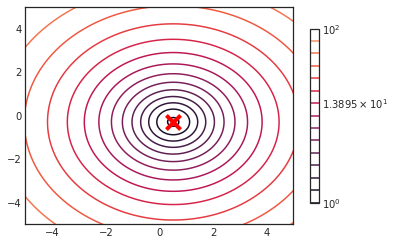

In [548]:
#with open('../../models/ridge_time.model', 'rb') as f:
#    print(pickle.load(f).model)
fig, ax = plt.subplots()
social_model.contour(data, ax)
#social_model.sample(data)


In [402]:
y_train_linear_hat = linear.predict(X_train_conc)
y_test_linear_hat = linear.predict(X_test_conc)

def compute_nll_mean(gt, predictions):
    """Computes the negative log likelihood from mean predictions.
    Useful to estimate the nll for linear models"""
    # Model output as mixture of one Gaussian with diagonal cov matrix.
    criterion = MixtureLoss(covariance_type='diagonal')
    # Mean is given by predictions.
    mu_l = predictions.reshape(-1,1,2)
    # Pi is one (only one component!)
    pi_l = np.ones((predictions.shape[0],1))
    
    var = np.var(gt - predictions, axis=0)
    # Variance is same for each example (by homoscedasticity)
    sigma_l = np.tile((var)[:,None], predictions.shape[0]).T.reshape(-1,1,2)
    return criterion(pi=torch.from_numpy(pi_l),
                     sigma=torch.from_numpy(sigma_l),
                     mu=torch.from_numpy(mu_l),
                     y=torch.from_numpy(gt))

compute_nll_mean(y_train_np, y_train_linear_hat),\
compute_nll_mean(y_test_np, y_test_linear_hat)

(tensor(1.9437, dtype=torch.float64), tensor(1.8875, dtype=torch.float64))